## Q1) 
### a) Which teamid won the game?
### b) How many goals did the winning team score? 
### c) Which period was the winning goal scored in?
### d) Limited to the period answered in c), how many shot attempts did the winning team have that were blocked?
### e) Create a scatter plot for all of the winning team's shot attempts limited to the period answered in c) and highlight the winning goal in a different colour.

Winning team is 315
Team 315 scored 4 goals
The game winning goal was scored in period #4
The number of blocked shots in period #4 by team 315 was 3


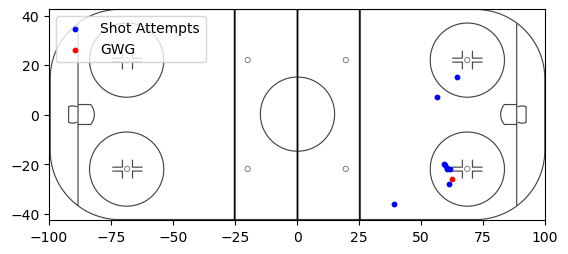

In [70]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
rawEventDF = pd.read_csv('DA_Tutorial24_Event_Data.csv')
xGDF = pd.read_csv('DA_Tutorial24_xG_Data.csv')

eventDF = pd.merge(rawEventDF, xGDF, how = 'left', on = ['compiledgametime','playerid'])

# Convert compiled game time to minutes and determine the period
eventDF['gameTimeMinutes'] = eventDF['compiledgametime'] / 60
eventDF['period'] = np.ceil(eventDF['gameTimeMinutes'] / 20).astype(int)

# Calculate the total goals by team
goals = eventDF.groupby('teamid')['goal'].sum()

teams = eventDF['teamid'].unique()

for team in teams:
    # Calculate cumulative goals for the team
    eventDF[f'{team}Goals'] = eventDF[eventDF['teamid'] == team]['goal'].cumsum()

    # Forward fill and backward fill the cumulative goals
    eventDF[f'{team}Goals'] = eventDF[f'{team}Goals'].ffill().bfill()

    # Set up the opposing team column
    eventDF['opp_teamid'] = eventDF['teamid'].apply(lambda x: next((tid for tid in teams if tid != x), None))
    
eventDF['goalDifferential'] = eventDF.apply(lambda row: row[f'{row["teamid"]}Goals'] - row[f'{row["opp_teamid"]}Goals'], axis=1)    



# Identify winning and losing teams
winning_team = goals.idxmax()
winning_team_goals = goals[winning_team]
losing_team = goals.idxmin()
losing_team_goals = goals[losing_team]
winning_margin = winning_team_goals - losing_team_goals

eventDF['is_gwg'] = False
latest_gwg_index = -1  # To store the index of the latest GWG

for index, row in eventDF.iterrows():
    if row['teamid'] == winning_team:
        if row['goalDifferential'] == 1:
            latest_gwg_index = index

# Mark the latest game-winning goal
if latest_gwg_index != -1:
    eventDF.at[latest_gwg_index, 'is_gwg'] = True

## GWG Period winner
gwg_winning_period = eventDF[eventDF['is_gwg']==True]['period'].item()


## Blocked Shots DataFrame
blockedShotsDF = eventDF[
    (eventDF['period'] == gwg_winning_period) & 
    (eventDF['teamid'] == winning_team) & 
    (eventDF['eventname'] == "shot") &
    (eventDF['type'].str.contains('blocked', case=False, na=False))
]

numBlockedShots = blockedShotsDF['type'].count()

## Find the shot attempts and gwg for the winning team
shotAttempts = eventDF[
    (eventDF['period'] == gwg_winning_period) & 
    (eventDF['teamid'] == winning_team) & 
    (eventDF['eventname'] == "shot") &
    (eventDF['is_gwg'] == False)
]

gwg_event = eventDF[(eventDF['is_gwg'] == True) & (eventDF['teamid'] == winning_team)]

## Plot the shot attempts in blue
plt.scatter(
    shotAttempts['xadjcoord'],
    shotAttempts['yadjcoord'],
    c = 'blue',
    s = 10,
    label = 'Shot Attempts')
# plot the gwg in red
plt.scatter(
    gwg_event['xadjcoord'],
    gwg_event['yadjcoord'],
    c = 'red',
    s=10,
    label = 'GWG')

## Change the axis to the specified margins and add the image with a legend
plt.axis([-100, 100, -42.5, 42.5])
image_name = 'rink_template.png'
img = plt.imread(image_name)
plt.imshow(img, zorder=0, extent=[-100, 100, -42.5, 42.5])
plt.legend(loc="upper left")

## A1)
### a) 
print(f"Winning team is {winning_team}")
### b)
print(f"Team {winning_team} scored {winning_team_goals} goals")
### c)
print(f"The game winning goal was scored in period #{gwg_winning_period}")
### d)
print(f"The number of blocked shots in period #{gwg_winning_period} by team {winning_team} was {numBlockedShots}")
### e)
plt.show()

## Q2)

### a) Which playerid scored the winning goal? 
### b) How many shot attempts did this player have on the powerplay for the full game? 
### c) Create a scatter plot for all of this player's powerplay shot attempts for the full game.
### d) If we told you these were Alex Ovechkin's powerplay shot attempts, what would you need to do to the Y coordinates for these attempts to appear from "Ovi's Office"? 
### e) Please re-create the scatter plot accordingly.

The playerid that scored the winning goal was 81408
playerid 81408 had 15 shot attempts on the power play


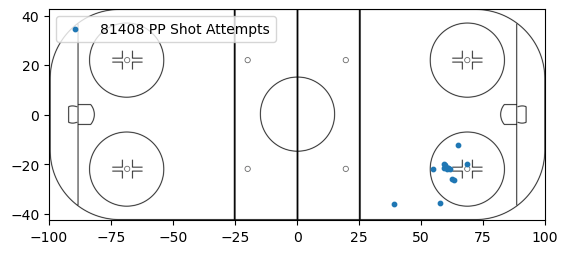

Flipped for correct side for Ovechkin


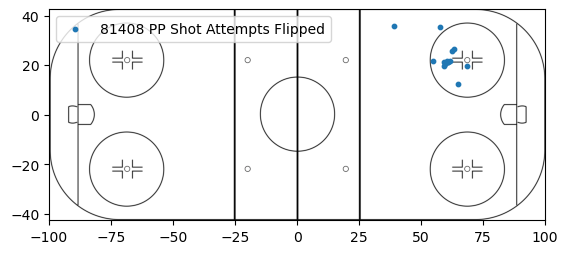

In [71]:
## A2)

## gwg playerid
gwgPlayerID = gwg_event['playerid'].item()

## powerplay shot attempts for the player
powerPlayShotAttempts = eventDF[
    (eventDF['playerid'] == gwgPlayerID) & 
    (eventDF['manpowersituation'] == "powerPlay") & 
    (eventDF['eventname'] == "shot")
]

numPowerPlayShotAttempts = powerPlayShotAttempts['type'].count()



### a)
print(f"The playerid that scored the winning goal was {gwgPlayerID}")
### b)
print(f"playerid {gwgPlayerID} had {numPowerPlayShotAttempts} shot attempts on the power play")
### c)

# plot the powerplay shot attempts 
plt.scatter(
    powerPlayShotAttempts['xadjcoord'],
    powerPlayShotAttempts['yadjcoord'],
    s=10,
    label = f'{gwgPlayerID} PP Shot Attempts')

## Change the axis to the specified margins and add the image with a legend
plt.axis([-100, 100, -42.5, 42.5])
image_name = 'rink_template.png'
img = plt.imread(image_name)
plt.imshow(img, zorder=0, extent=[-100, 100, -42.5, 42.5])
plt.legend(loc="upper left")


plt.show()
### d)
## If this player was alexander ovechkin, we would need to flip the y axis as he is a left handed shot and most of his shot attempts on the PP occur from the left dot.
### e)

# plot the powerplay shot attempts 
plt.scatter(
    powerPlayShotAttempts['xadjcoord'],
    powerPlayShotAttempts['yadjcoord']* -1,
    s=10,
    label = f'{gwgPlayerID} PP Shot Attempts Flipped')

## Change the axis to the specified margins and add the image with a legend
plt.axis([-100, 100, -42.5, 42.5])
image_name = 'rink_template.png'
img = plt.imread(image_name)
plt.imshow(img, zorder=0, extent=[-100, 100, -42.5, 42.5])
plt.legend(loc="upper left")
print('Flipped for correct side for Ovechkin')
plt.show()

## Q3)
### a) Build a visual to display the following information for the Assistant Coach in a clear and digestible way: What was the even strength pass completion rate for each team broken down by zone? (please use the zone of pass origin)
### b) From this visual, what was teamid 315's even strength pass completion rate in the offensive zone?
### c) Which zone was most challenging to complete passes in at even strength? 
### d) What was teamid 311's all strengths slot save percentage? (The slot includes innerSlot, westOuterSlot, & eastOuterSlot. Please format this answer as X.XXX)

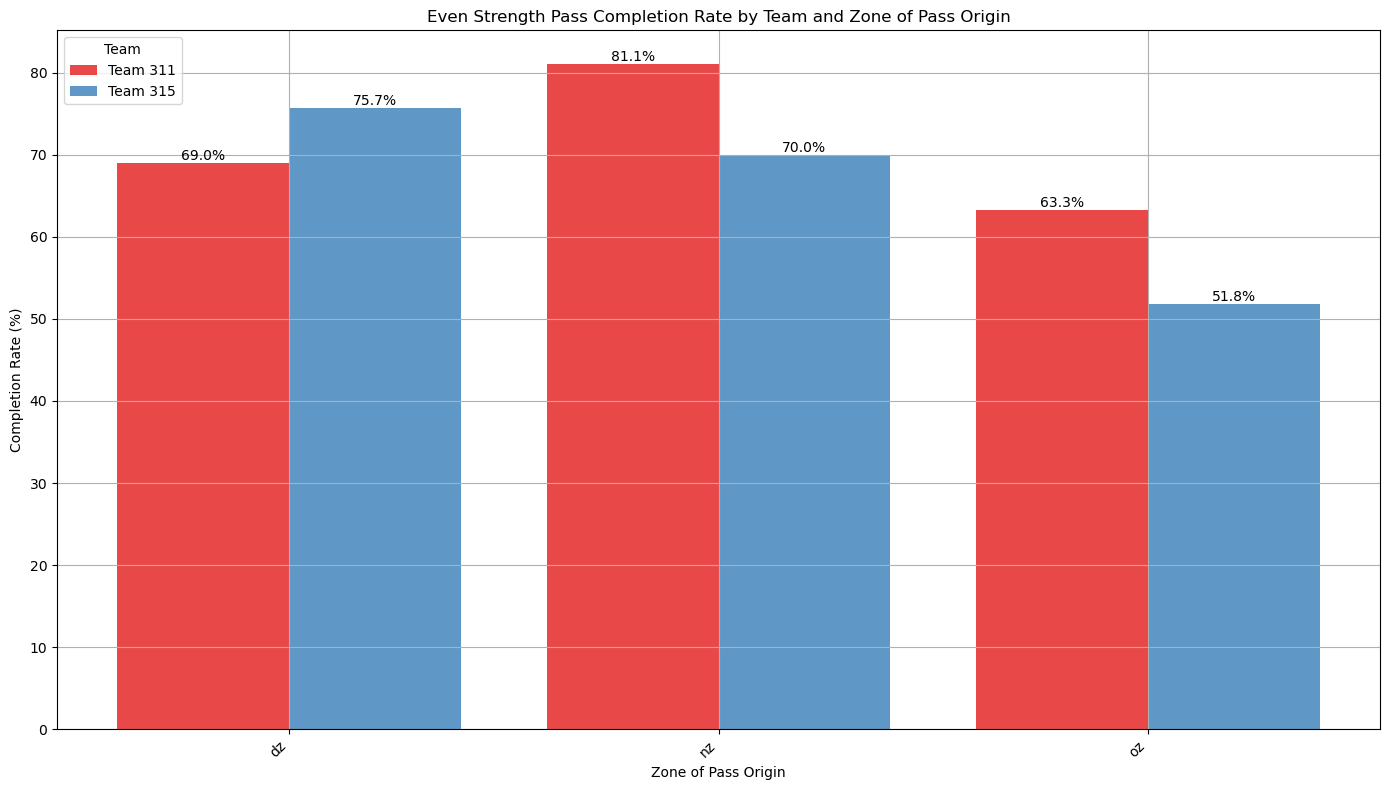

Team 315's pass completion percentage in the offensive zone was 51.8%
The hardest zone to complete passes was the oz at 57.4%
The Save Percentage for Slot Shots against for team 311 is 0.917


In [72]:
## A3) 
even_strength_passes = eventDF[
    (eventDF['manpowersituation'] == 'evenStrength') & 
    (eventDF['eventname'] == 'pass')]


ev_passes_by_zone = even_strength_passes.groupby(['teamid','zone'])['type'].count().reset_index().rename(columns = {'type':'attemptedPass'})
ev_passes_by_zone_completed = even_strength_passes[even_strength_passes['outcome'] =='successful'].groupby(['teamid','zone'])['type'].count().reset_index().rename(columns = {'type':'succesfulPass'})

ev_passes_by_zone_merged = pd.merge(ev_passes_by_zone,ev_passes_by_zone_completed, how = 'left', on = ['teamid','zone'])
ev_passes_by_zone_merged['completionPct'] = ev_passes_by_zone_merged['succesfulPass'] / ev_passes_by_zone_merged['attemptedPass']


# Create a color map for teams
teams = ev_passes_by_zone_merged['teamid'].unique()
colors = plt.get_cmap('Set1').colors[:len(teams)]
color_map = dict(zip(teams, colors))

# Prepare data for plotting
zones = ev_passes_by_zone_merged['zone'].unique()
bar_width = 0.8 / len(teams)  # Width of each bar
opacity = 0.8

# Set up the plot
plt.figure(figsize=(14, 8))

for i, team in enumerate(teams):
    team_data = ev_passes_by_zone_merged[ev_passes_by_zone_merged['teamid'] == team]
    bar_positions = np.arange(len(zones)) + i * bar_width  # Calculate bar positions
    bars = plt.bar(
        bar_positions,
        round(team_data['completionPct']*100,1),
        width=bar_width,
        color=color_map[team],
        label=f'Team {team}',
        alpha=opacity
    )

    # Add labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f'{yval:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10
        )

# Adding labels and title
plt.xlabel('Zone of Pass Origin')
plt.ylabel('Completion Rate (%)')
plt.title('Even Strength Pass Completion Rate by Team and Zone of Pass Origin')

# Set x-ticks to the middle of the grouped bars
plt.xticks(
    np.arange(len(zones)) + bar_width * (len(teams) - 1) / 2,
    zones,
    rotation=45,
    ha='right'
)

# Add legend and grid
plt.legend(title='Team', loc='upper left')
plt.grid(True)

# Adjust layout
plt.tight_layout()

## Completed passes in OZ for team 315
three15ozPassComp = ev_passes_by_zone_merged[(ev_passes_by_zone_merged['teamid'] == 315 ) & (ev_passes_by_zone_merged['zone'] == 'oz')]['completionPct'].item()

## All Teams completed passes
allTeamPasses = ev_passes_by_zone_merged.groupby('zone')[['attemptedPass','succesfulPass']].sum()
allTeamPasses['completionPct'] = allTeamPasses['succesfulPass'] / allTeamPasses['attemptedPass']

hardestZoneComp = allTeamPasses['completionPct'].idxmin()
hardestZoneCompPct = allTeamPasses['completionPct'].min()

## Save Pct for team 311 in the slot
slotShotsAgainst = eventDF[(eventDF['opp_teamid'] == 311)&
                           (eventDF['eventname'] == "shot")&
                           (eventDF['outcome'] == "successful")&
                           (eventDF['playsection'].str.contains('slot', case=False, na=False))]

slotSavePct = round((slotShotsAgainst['type'].count() - slotShotsAgainst[slotShotsAgainst['goal'] == 1]['type'].count()) / slotShotsAgainst['type'].count(),3)

### a)
# Show plot
plt.show()
### b)
print(f"Team 315's pass completion percentage in the offensive zone was {round(three15ozPassComp*100,1)}%")
### c)
print(f"The hardest zone to complete passes was the {hardestZoneComp} at {round(hardestZoneCompPct*100,1)}%")
### d)
print(f"The Save Percentage for Slot Shots against for team 311 is {slotSavePct}")

## Q4)
### a) Assuming the centre of the net is at X=89 (goal line), Y=0 (centre ice), what was the all strengths average shot distance to the centre of the net for teamid 315's shots on goal from the outside north west playsection?
### b) What was teamid 315's all strengths Goals Saved Above Expected from the outside north west playsection? (please format as X.XX) 
### c) What does this tell us about their performance from this area?

In [73]:
## A4)

##team 315 NW Shot Distance
nwShotDistance = round(eventDF[(eventDF['teamid'] == 315)&
                           (eventDF['eventname'] == "shot")&
                           (eventDF['outcome'] == "successful")&
                           (eventDF['playsection']=="outsideNorthWest")]['yadjcoord'].mean(),1)


##team 315 NW Shots and expected goals against
nwShotsAgainst = eventDF[(eventDF['opp_teamid'] == 315)&
                           (eventDF['eventname'] == "shot")&
                           (eventDF['outcome'] == "successful")&
                           (eventDF['playsection']=="outsideNorthWest")]

nwGoalsAgainst = nwShotsAgainst['goal'].sum()
nwXGAgainst = nwShotsAgainst['xg'].sum()

nwGSAX = round(nwXGAgainst - nwGoalsAgainst,2)

### a)
print(f"The average shot distance from Center Ice for Team 315's SOG from the Outside North West Section was {abs(nwShotDistance)}'")
### b)
print(f"For team 315, their goals saved above expected from the Outside North West Section was {(nwGSAX)}")
### c)
print('From this area, team 315 did a good job limiting quality shot attempts, as the total number of xg against was 0.33 on 5 shots, however, their goalie let in a below average goal as the xg was 0.07 for the shot. Typically this is an area where a goalie should have a high save percentage.') 

The average shot distance from Center Ice for Team 315's SOG from the Outside North West Section was 23.5'
For team 315, their goals saved above expected from the Outside North West Section was -0.67
From this area, team 315 did a good job limiting quality shot attempts, as the total number of xg against was 0.33 on 5 shots, however, their goalie let in a below average goal as the xg was 0.07 for the shot. Typically this is an area where a goalie should have a high save percentage.


## Q5)
### a) If a "Shot Assist" is defined as a sequence of events where there is: 1) a successful pass followed by 2) a successful reception *by a teammate* and then without giving up the puck 3) the receiving player has a shot attempt, create a column flagging shots that have a Shot Assist. How many all strengths shot attempts did playerid 79380 have that were assisted?
### b) Assume the full xG value from the shot attempt can be credited to the passer for their shot assist, which *passer id* created the most xG via shot assists for their teammates?
### c) Plot a single diagram of this passer's shot assists (pass to the shooting player's reception) and the corresponding shots (shooter's reception to their shot). Hint: Don't forget what you learned in Q2d) about plotting Y coordinates.
### d) For shooters who had more than 1 shot attempt that was assisted, what was the longest average time from their receptions to their shots?
### e) Which playerid had the longest average time answered in d)?

Player ID 79380 had 7 shot attempts that were assisted
The player who had the highest shot assist xg was player 94531 with 0.66 expected Assists


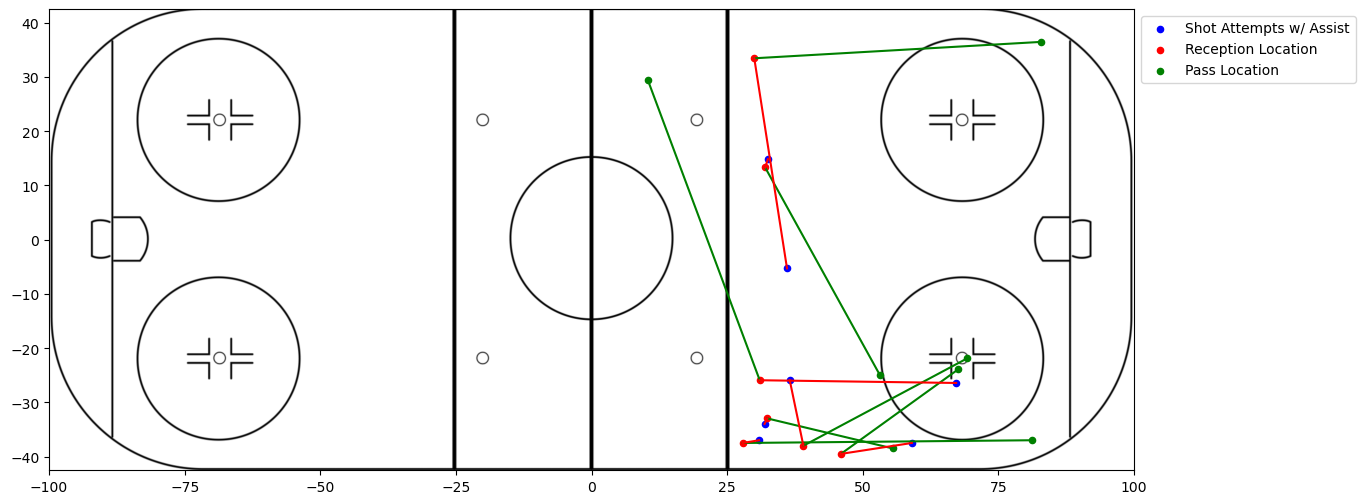

The longest hold time from reception to shot on average was 3.2 seconds
The player with the longest hold time from reception to shot on average was player 112050


In [74]:
## A5)


# Create flags for successful receptions and shot assists
eventDF['successfulReception'] = False
eventDF['shotAssist'] = False

# Shift columns to compare events
eventDF['last_eventname'] = eventDF['eventname'].shift(1)
eventDF['last_outcome'] = eventDF['outcome'].shift(1)
eventDF['last_playerid'] = eventDF['playerid'].shift(1)
eventDF['last_teamid'] = eventDF['teamid'].shift(1)
eventDF['last_xcoord'] = eventDF['xadjcoord'].shift(1)
eventDF['last_ycoord'] = eventDF['yadjcoord'].shift(1)
eventDF['last_gametime'] = eventDF['compiledgametime'].shift(1)



# Flag rows where a successful pass is followed by a successful reception
eventDF.loc[
    (eventDF['eventname'] == 'reception') &
    (eventDF['outcome'] == 'successful') &
    (eventDF['last_eventname'] == 'pass') &
    (eventDF['last_outcome'] == 'successful') &
    (eventDF['teamid'] == eventDF['last_teamid']),
    'successfulReception'
] = True

# Ensure compatibility of data types
eventDF['last_playerid'] = eventDF['last_playerid'].astype(float)


# Flag the original passer of the successful reception
eventDF.loc[eventDF['successfulReception'], 'passerid'] = eventDF['last_playerid']
eventDF.loc[eventDF['successfulReception'], 'passOriginXCoord'] = eventDF['last_xcoord']
eventDF.loc[eventDF['successfulReception'], 'passOriginYCoord'] = eventDF['last_ycoord']

eventDF['passerid'] = eventDF['passerid'].astype(float, errors='ignore')

# Shift columns to compare with the original passer
eventDF['last_successfulReception'] = eventDF['successfulReception'].shift(1)
eventDF['last_passerid'] = eventDF['passerid'].shift(1)

# Check if the row fits the definition of a shot assist
eventDF.loc[
    (eventDF['eventname'] == 'shot') &
    (eventDF['last_successfulReception']) &
    (eventDF['last_playerid'] == eventDF['playerid']) &
    (eventDF['teamid'] == eventDF['last_teamid']),
    'shotAssist'
] = True

# Get the original passer for the shot assist
eventDF['last_passerid'] = eventDF['last_passerid'].astype(float, errors='ignore')
eventDF.loc[eventDF['shotAssist'], 'originalPasserID'] = eventDF['last_passerid']
eventDF.loc[eventDF['shotAssist'], 'passXAdjCoord'] = eventDF['passOriginXCoord'].shift(1)
eventDF.loc[eventDF['shotAssist'], 'passYAdjCoord'] = eventDF['passOriginYCoord'].shift(1)
eventDF.loc[eventDF['shotAssist'], 'receptionXAdjCoord'] = eventDF['last_xcoord']
eventDF.loc[eventDF['shotAssist'], 'receptionYAdjCoord'] = eventDF['last_ycoord']
eventDF.loc[eventDF['shotAssist'], 'receptionCompiledGameTime'] = eventDF['last_gametime']
eventDF.loc[eventDF['shotAssist'], 'receptionToShot'] = eventDF['compiledgametime'] - eventDF['receptionCompiledGameTime']

# Drop auxiliary columns
columns_to_drop = ['last_eventname', 'last_outcome', 'last_playerid', 'last_teamid',
                   'passerid', 'last_successfulReception', 'last_passerid', 
                   'last_xcoord', 'last_ycoord', 'passOriginXCoord', 'passOriginYCoord']
eventDF.drop(columns=columns_to_drop, inplace=True)


## get total shotAssists and xG
xAssists = eventDF.groupby('originalPasserID')['xg'].sum()
shotAssists = xAssists.idxmax()
shotAssistsNum = xAssists.max()


# Filter for the specific player and shot assists
shotsAtt = eventDF[(eventDF['playerid'] == shotAssists) & (eventDF['shotAssist'])]



# Plot the data
plt.figure(figsize=(14, 8))
plt.scatter(shotsAtt['xadjcoord'], shotsAtt['yadjcoord'], c='blue', s=20, label='Shot Attempts w/ Assist')
plt.scatter(shotsAtt['receptionXAdjCoord'], shotsAtt['receptionYAdjCoord'], c='red', s=20, label='Reception Location')
plt.scatter(shotsAtt['passXAdjCoord'], shotsAtt['passYAdjCoord'], c='green', s=20, label='Pass Location')

# Connect pass origin to reception
for idx, row in shotsAtt.iterrows():
    plt.plot([row['passXAdjCoord'], row['receptionXAdjCoord']],
             [row['passYAdjCoord'], row['receptionYAdjCoord']], 'g-')

# Connect reception to shot attempt
for idx, row in shotsAtt.iterrows():
    plt.plot([row['receptionXAdjCoord'], row['xadjcoord']],
             [row['receptionYAdjCoord'], row['yadjcoord']], 'r-')

# Change the axis to the specified margins and add the image with a legend
plt.axis([-100, 100, -42.5, 42.5])
image_name = 'rink_template.png'
img = plt.imread(image_name)
plt.imshow(img, zorder=0, extent=[-100, 100, -42.5, 42.5])

# Move the legend outside the plot area
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))


##Filter for more than 1 shot attempt

allShotAtt = eventDF[eventDF['eventname'] == 'shot']
totalShotAtt = allShotAtt.groupby('playerid')['type'].size().reset_index(name='count')
multipleShotAtt = totalShotAtt[totalShotAtt['count']>1]

mergedShotsMultiples = allShotAtt.merge(multipleShotAtt['playerid'],on = 'playerid')

longestHoldTime = mergedShotsMultiples.groupby('playerid')['receptionToShot'].mean()
longestHoldTimeNum = longestHoldTime.max()
longestHoldTimeID = longestHoldTime.idxmax()

### a)
print(f"Player ID 79380 had {shotsAtt['type'].count()} shot attempts that were assisted")
### b)
print(f"The player who had the highest shot assist xg was player {int(shotAssists)} with {round(shotAssistsNum,2)} expected Assists")
### c)
plt.show()
### d)
print(f'The longest hold time from reception to shot on average was {round(longestHoldTimeNum,1)} seconds')
### e)
print(f'The player with the longest hold time from reception to shot on average was player {longestHoldTimeID}')

## Q6)
### a) Which teamid won the all strengths xG battle?
### b) What was the losing team's all strengths xG? (round to X.XX)
### c) Based on the answers in a) and b), what does this tell you about how the game went?

In [75]:
## A6)

# Calculate the total goals by team
xg = eventDF.groupby('teamid')['xg'].sum()

winning_team_xg = xg.idxmax()
winning_team_xg_value = xg.max()
losing_team_xg = xg.idxmin()
losing_team_xg_value = xg.min()

### a)
print(f"The team that won the all strengths xG battle was {winning_team_xg}")
### b)
print(f"The team that lost the all strengths xG battle was {losing_team_xg} with {round(losing_team_xg_value,2)}")
### c)

The team that won the all strengths xG battle was 311
The team that lost the all strengths xG battle was 315 with 4.1


## Q7) 
### With the information provided in the data files and the columns you've been asked to create in the questions above, are there other features you can build to help create an xG model? Please create these features. 
### a) Using a statistical technique of your choice, show the highest predictors of a goal within your feature set. For your answer, clearly list your xG predictors in a python list from most predictive to least, for example: ['highest', 'middle', 'lowest'].
### b) Please explain why you chose the statistical technique in 7a) and at a high level (as if you were talking to a non-technical Assistant Coach) please provide a short form explanation of your results in 7a) and recommendations for the coach.
### c) If you had full seasons worth of shot event data, what are the top 3 model algorithms you would test for building an xG model? Please present these in the same python list format as 7a), for example: ['1st choice', '2nd choice', '3rd choice']
### d) Please explain the reasoning for your choices in 7c) in short answer form.

In [78]:
featuresDF = eventDF[eventDF['eventname'] == 'shot']

label_encoder = LabelEncoder()
featuresDF['manpowersituation'] = label_encoder.fit_transform(featuresDF['manpowersituation'])
featuresDF['zone'] = label_encoder.fit_transform(featuresDF['zone'])
featuresDF['teamid'] = label_encoder.fit_transform(featuresDF['teamid'])
featuresDF['playsection'] = label_encoder.fit_transform(featuresDF['playsection'])
featuresDF['successfulReception'] = label_encoder.fit_transform(featuresDF['successfulReception'])
featuresDF['shotAssist'] = label_encoder.fit_transform(featuresDF['shotAssist'])
featuresDF['outcome'] = label_encoder.fit_transform(featuresDF['outcome'])



X = featuresDF[['manpowersituation','zone','playerid','teamid','xadjcoord','yadjcoord','outcome','playsection','period','goalDifferential','successfulReception','shotAssist']]  # Features



y = featuresDF['goal']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

importances = model.feature_importances_
feature_names = X.columns
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")
sorted_features = [feature for feature, _ in feature_importances]

### a)
print(sorted_features)
### b)
### c)
### d)

Feature: xadjcoord, Importance: 0.2653689285865264
Feature: goalDifferential, Importance: 0.1571633975301462
Feature: yadjcoord, Importance: 0.14925644799138207
Feature: period, Importance: 0.09713440345495304
Feature: playerid, Importance: 0.08834935670151073
Feature: playsection, Importance: 0.08734601403753736
Feature: outcome, Importance: 0.08205692722082797
Feature: manpowersituation, Importance: 0.030553984962229285
Feature: shotAssist, Importance: 0.028959284095769092
Feature: teamid, Importance: 0.013811255419117832
Feature: zone, Importance: 0.0
Feature: successfulReception, Importance: 0.0
['xadjcoord', 'goalDifferential', 'yadjcoord', 'period', 'playerid', 'playsection', 'outcome', 'manpowersituation', 'shotAssist', 'teamid', 'zone', 'successfulReception']


C:\Users\apgol\AppData\Local\Temp\ipykernel_24492\3499016205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featuresDF['manpowersituation'] = label_encoder.fit_transform(featuresDF['manpowersituation'])
C:\Users\apgol\AppData\Local\Temp\ipykernel_24492\3499016205.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featuresDF['zone'] = label_encoder.fit_transform(featuresDF['zone'])
C:\Users\apgol\AppData\Local\Temp\ipykernel_24492\3499016205.py:6: SettingWithCopyWarning: 
A value is trying to be set on